In [12]:
library(tidyverse)
library(janitor)

In [13]:
players_url  <- "https://raw.githubusercontent.com/bonyoongoo/ubc-dsci100-minecraft-forecasting/refs/heads/main/data/players.csv"
sessions_url <- "https://raw.githubusercontent.com/bonyoongoo/ubc-dsci100-minecraft-forecasting/refs/heads/main/data/sessions.csv"

players  <- read_csv(players_url) |> clean_names()
sessions <- read_csv(sessions_url) |> clean_names()


nrow(players); ncol(players); names(players)
nrow(sessions); ncol(sessions); names(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 196

[1] 7

[1] "experience"   "subscribe"    "hashed_email" "played_hours" "name"        
[6] "gender"       "age"

[1] 1535

[1] 5

[1] "hashed_email"        "start_time"          "end_time"           
[4] "original_start_time" "original_end_time"

In [14]:
players <- players |>
  mutate(
    newsletter_subscribed = ifelse(
      is.na(subscribe), NA_character_,
      ifelse(subscribe, "Subscribed", "Not subscribed")
    ),
    newsletter_subscribed = as_factor(newsletter_subscribed)
  )

players |>
  group_by(newsletter_subscribed) |>
  summarize(players = n())


newsletter_subscribed,players
<fct>,<int>
Subscribed,144
Not subscribed,52


In [15]:

nrow(players); ncol(players)
names(players)


nrow(sessions); ncol(sessions)
names(sessions)

[1] 196

[1] 8

[1] "experience"            "subscribe"             "hashed_email"         
[4] "played_hours"          "name"                  "gender"               
[7] "age"                   "newsletter_subscribed"

[1] 1535

[1] 5

[1] "hashed_email"        "start_time"          "end_time"           
[4] "original_start_time" "original_end_time"

In [16]:
players |>
  summarize(across(everything(), ~ sum(is.na(.))))
sessions |>
  summarize(across(everything(), ~ sum(is.na(.))))

experience,subscribe,hashed_email,played_hours,name,gender,age,newsletter_subscribed
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,2,0


hashed_email,start_time,end_time,original_start_time,original_end_time
<int>,<int>,<int>,<int>,<int>
0,0,2,0,2


In [17]:
players |>
  summarize(across(everything(), ~ paste(class(.x)[1])))
sessions |>
  summarize(across(everything(), ~ paste(class(.x)[1])))

experience,subscribe,hashed_email,played_hours,name,gender,age,newsletter_subscribed
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
character,logical,character,numeric,character,character,numeric,factor


hashed_email,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<chr>,<chr>
character,character,character,numeric,numeric


In [18]:
players |>
  summarize(across(where(is.numeric), ~ round(mean(.x, na.rm = TRUE), 2)))


played_hours,age
<dbl>,<dbl>
5.85,21.14


Observations and potential issues

The players dataset has 8 columns and around 196 rows. The sessions dataset has 5 columns and about 1 500 rows.

Some minor missing values are present in a few variables such as age and played_hours.

Numeric variables (especially played_hours) are right-skewed — many players have very low or zero total hours played, with a few high outliers.

The name and hashed_email columns act as unique identifiers; they contain personally identifiable information and will be excluded from modelling to avoid leakage or privacy issues.

The experience and gender columns are categorical and will need encoding before modelling.

The subscribe column has been cleaned into the new binary variable newsletter_subscribed, which will be the response variable.

The sessions data include start_time and end_time stored as text strings; these may need to be converted to proper datetime values later during the group phase for any time-based analyses.

No other serious data-quality problems are visible at this stage.

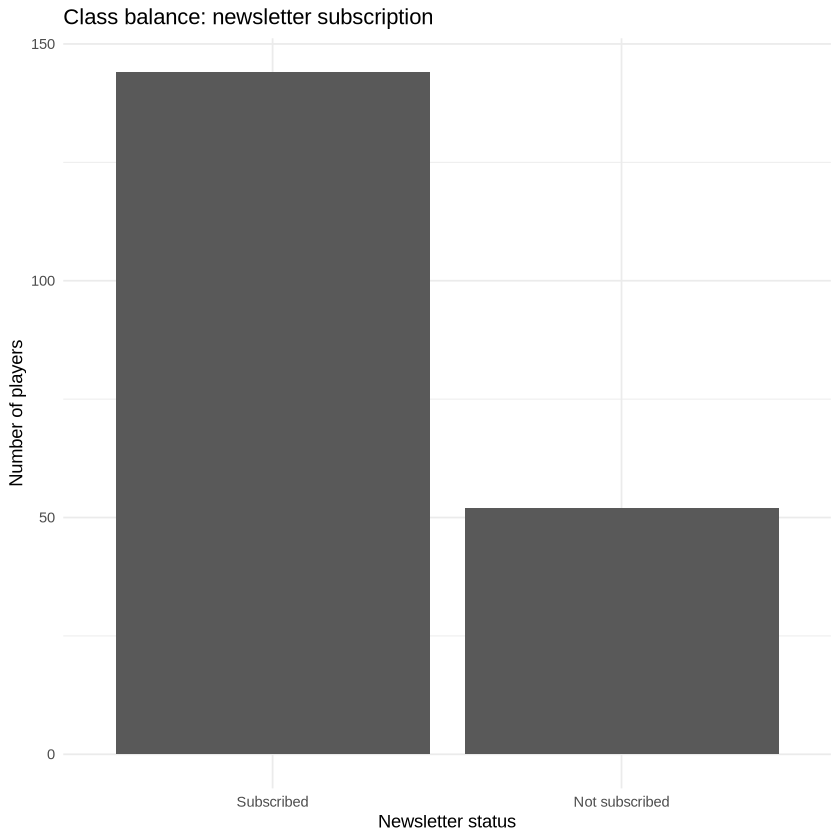

In [19]:
players |>
  group_by(newsletter_subscribed) |>
  summarize(players = n()) |>
  ggplot(aes(x = newsletter_subscribed, y = players)) +
  geom_bar(stat = "identity") +
  labs(x = "Newsletter status",
       y = "Number of players",
       title = "Class balance: newsletter subscription") +
  theme_minimal()


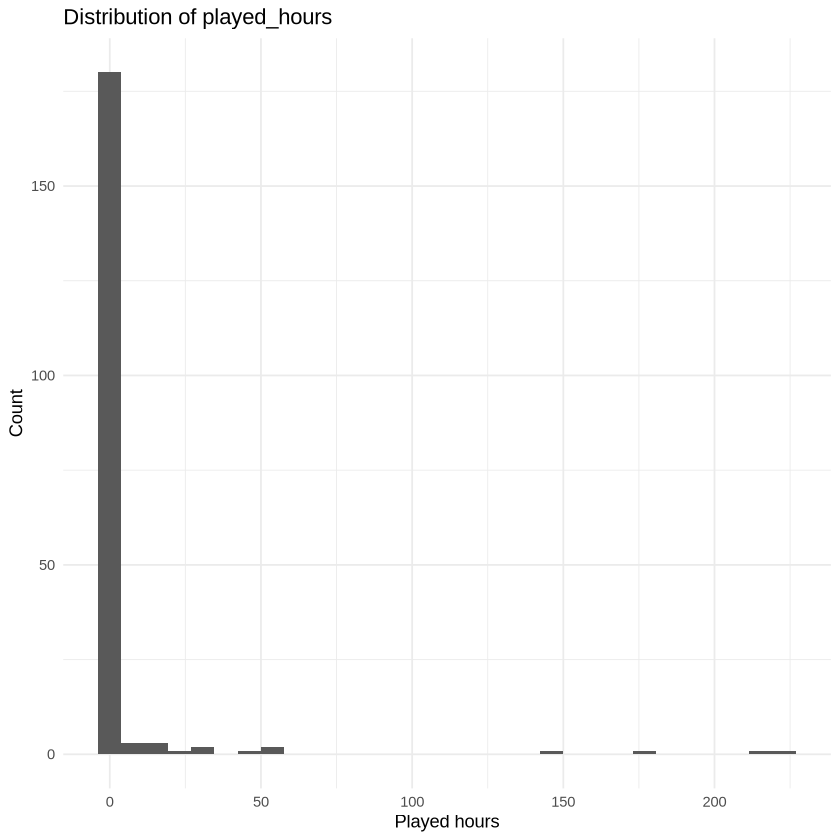

In [20]:
players |>
  ggplot(aes(x = played_hours)) +
  geom_histogram(bins = 30) +
  labs(x = "Played hours",
       y = "Count",
       title = "Distribution of played_hours") +
  theme_minimal()


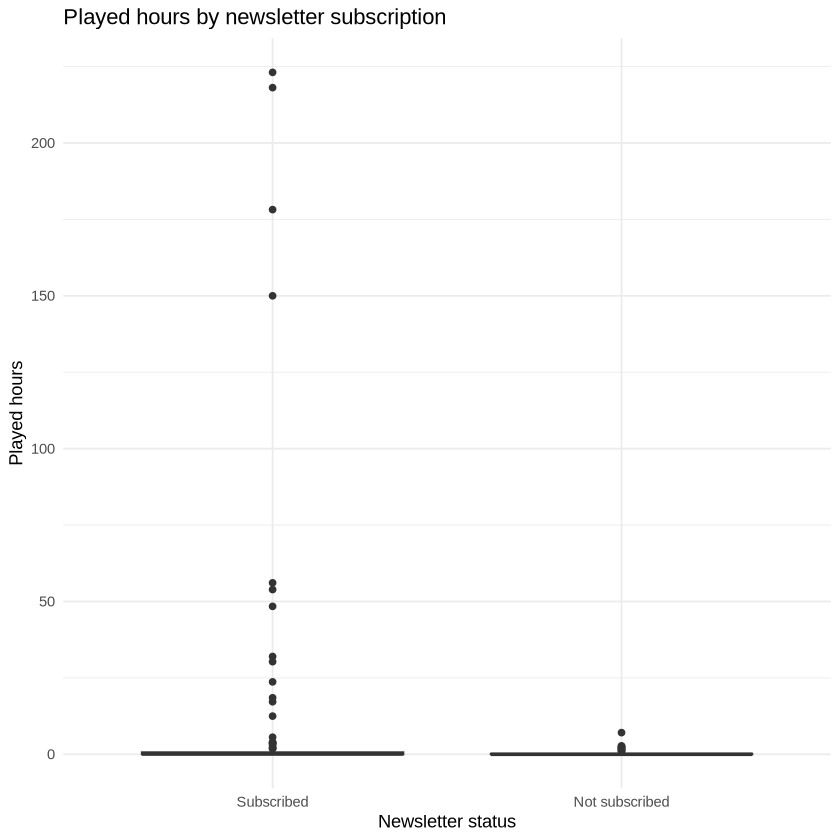

In [12]:
players |>
  filter(!is.na(newsletter_subscribed)) |>
  ggplot(aes(x = newsletter_subscribed, y = played_hours)) +
  geom_boxplot() +
  labs(x = "Newsletter status",
       y = "Played hours",
       title = "Played hours by newsletter subscription") +
  theme_minimal()


- The bar chart shows more players subscribed than not, suggesting mild class imbalance.
- The histogram reveals `played_hours` is highly right-skewed; most players have very few hours while a few play much more.
- The boxplot suggests subscribers generally spend more total hours playing than non-subscribers.
- These visual patterns indicate that play time could be a useful predictor for newsletter subscription.

Methods and Plan